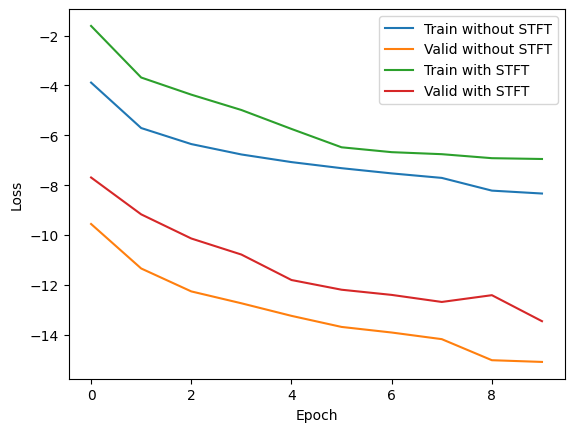

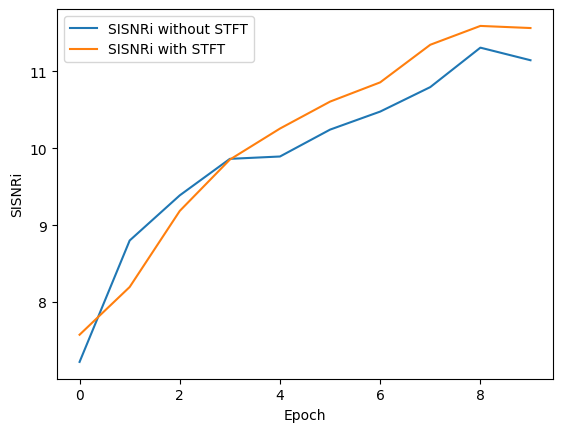

In [3]:
import json 
import matplotlib.pyplot as plt

with open('outputs/exp_/history.json') as f:
    history = json.load(f)


with open('outputs/stft_/history_stft.json') as f:
    history_stft = json.load(f)

train = [d['train'] for d in history]
valid = [d['valid'] for d in history]
trian_stft = [d['train'] for d in history_stft]
valid_stft = [d['valid'] for d in history_stft]


plt.plot(train, label='Train loss without STFT')
plt.plot(valid, label='Valid loss without STFT')
plt.plot(trian_stft, label='Train loss with STFT')
plt.plot(valid_stft, label='Valid loss with STFT')
plt.legend()
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.show()

sisnr = [d['sisnr'] for d in history]
sisnr_stft = [d['sisnr'] for d in history_stft]
plt.plot(sisnr, label='SISNRi without STFT')
plt.plot(sisnr_stft, label='SISNRi with STFT')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('SISNRi')
plt.show()

In [24]:
from svoice.models.swave import SWave
# calculate number of parameters
model= SWave(64,8,64,4,2,800,4,False)
num_params = sum(p.numel() for p in model.parameters())*4 / 2**20   # 4 bytes/number
print(f'The model has {num_params} MB trainable parameters')

The model has 4.852054595947266 MB trainable parameters


In [9]:
from svoice.models.sisnr_loss import cal_si_snr_with_pit, reorder_source, cal_loss
import torch

source1 = torch.randn(1, 1, 8)
source2 = torch.randn(1, 1, 8)
length = torch.tensor([8])
print(cal_loss(source1, source2,length)[0])


tensor(3.8656)


In [12]:
'''STFT-based Loss modules.'''

import torch
import torch.nn.functional as F


def stft(x, fft_size, hop_size, win_length, window):
    """Perform STFT and convert to magnitude spectrogram.
    Args:
        x (Tensor): Input signal tensor (B, T).
        fft_size (int): FFT size.
        hop_size (int): Hop size.the distance between neighboring sliding window frames.
        win_length (int): Window length.
        window (str): Window function type.
    Returns:
        Tensor: Magnitude spectrogram (B, #frames, fft_size // 2 + 1).
    """
    x_stft = torch.stft(x, fft_size, hop_size, win_length, window)
    real = x_stft[..., 0]
    imag = x_stft[..., 1]

    # NOTE(kan-bayashi): clamp is needed to avoid nan or inf
    return torch.sqrt(torch.clamp(real ** 2 + imag ** 2, min=1e-7)).transpose(2, 1)


class SpectralConvergengeLoss(torch.nn.Module):
    """Spectral convergence loss module."""

    def __init__(self):
        """Initilize spectral convergence loss module."""
        super(SpectralConvergengeLoss, self).__init__()

    def forward(self, x_mag, y_mag):
        """Calculate forward propagation.
        Args:
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return torch.norm(y_mag - x_mag, p="fro") / torch.norm(y_mag, p="fro")


class LogSTFTMagnitudeLoss(torch.nn.Module):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initilize los STFT magnitude loss module."""
        super(LogSTFTMagnitudeLoss, self).__init__()

    def forward(self, x_mag, y_mag):
        """Calculate forward propagation.
        Args:
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Log STFT magnitude loss value.
        """
        return F.l1_loss(torch.log(y_mag), torch.log(x_mag))


class STFTLoss(torch.nn.Module):
    """STFT loss module."""

    def __init__(self, fft_size=1024, shift_size=120, win_length=600, window="hann_window"):
        """Initialize STFT loss module."""
        super(STFTLoss, self).__init__()
        self.fft_size = fft_size
        self.shift_size = shift_size
        self.win_length = win_length
        self.register_buffer("window", getattr(torch, window)(win_length))
        self.spectral_convergenge_loss = SpectralConvergengeLoss()
        self.log_stft_magnitude_loss = LogSTFTMagnitudeLoss()

    def forward(self, x, y):
        """Calculate forward propagation.
        Args:
            x (Tensor): Predicted signal (B, T).
            y (Tensor): Groundtruth signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value.
            Tensor: Log STFT magnitude loss value.
        """
        x_mag = stft(x, self.fft_size, self.shift_size, self.win_length, self.window)
        y_mag = stft(y, self.fft_size, self.shift_size, self.win_length, self.window)
        sc_loss = self.spectral_convergenge_loss(x_mag, y_mag)
        mag_loss = self.log_stft_magnitude_loss(x_mag, y_mag)

        return sc_loss, mag_loss


class MultiResolutionSTFTLoss(torch.nn.Module):
    """Multi resolution STFT loss module."""

    def __init__(self,
                 fft_sizes=[2],
                 hop_sizes=[2],
                 win_lengths=[2],
                 window="hann_window", factor_sc=0.1, factor_mag=0.1):
        """Initialize Multi resolution STFT loss module.
        Args:
            fft_sizes (list): List of FFT sizes.
            hop_sizes (list): List of hop sizes.
            win_lengths (list): List of window lengths.
            window (str): Window function type.
            factor (float): a balancing factor across different losses.
        """
        super(MultiResolutionSTFTLoss, self).__init__()
        assert len(fft_sizes) == len(hop_sizes) == len(win_lengths)
        self.stft_losses = torch.nn.ModuleList()
        for fs, ss, wl in zip(fft_sizes, hop_sizes, win_lengths):
            self.stft_losses += [STFTLoss(fs, ss, wl, window)]
        self.factor_sc = factor_sc
        self.factor_mag = factor_mag

    def forward(self, x, y):
        """Calculate forward propagation.
        Args:
            x (Tensor): Predicted signal (B, T).
            y (Tensor): Groundtruth signal (B, T).
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(x, y)
            sc_loss += sc_l
            mag_loss += mag_l
        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)

        return self.factor_sc*sc_loss, self.factor_mag*mag_loss

In [14]:
cal_stft_loss=MultiResolutionSTFTLoss()
print(cal_stft_loss(source1.squeeze(1),source2.squeeze(1)))

(tensor(0.0533), tensor(0.0660))


In [2]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR,MultiStepLR
from torchvision.models import resnet18
import torch

In [23]:
model=resnet18()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
sched=StepLR(optimizer, step_size=4, gamma=0.2)
# sched=MultiStepLR(optimizer, milestones=[4], gamma=0.1)
for i in range(5):
    print(i,',',sched.state_dict())
    sched.step()

0 , {'step_size': 4, 'gamma': 0.2, 'base_lrs': [0.001], 'last_epoch': 0, '_step_count': 1, '_get_lr_called_within_step': False, '_last_lr': [0.001]}
1 , {'step_size': 4, 'gamma': 0.2, 'base_lrs': [0.001], 'last_epoch': 1, '_step_count': 2, '_get_lr_called_within_step': False, '_last_lr': [0.001]}
2 , {'step_size': 4, 'gamma': 0.2, 'base_lrs': [0.001], 'last_epoch': 2, '_step_count': 3, '_get_lr_called_within_step': False, '_last_lr': [0.001]}
3 , {'step_size': 4, 'gamma': 0.2, 'base_lrs': [0.001], 'last_epoch': 3, '_step_count': 4, '_get_lr_called_within_step': False, '_last_lr': [0.001]}
4 , {'step_size': 4, 'gamma': 0.2, 'base_lrs': [0.001], 'last_epoch': 4, '_step_count': 5, '_get_lr_called_within_step': False, '_last_lr': [0.0002]}


/root/miniconda/envs/svoice/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


第[5,8,9]个epoch会更新学习率，从0开始索引